In [1]:
%reset -f

## DDQN

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from typing import *
from abc import ABC, abstractmethod
pp=print

"""
Quand on update la target à chaque pas de temps, ce @tf.function divise la durée d'un époque par 2.
La moyennation des poids a un coup non negligeable.
A chaque fois que l'on change tau, tensorflow doit "retracer" la fonction et il met un warning.
donc: ne pas trop changer tau !   
"""
#todo préciser la signature du @tf.function

@tf.function
def update_target(target_model, model,tau):
    target_weights=target_model.trainable_variables
    weights=model.trainable_variables
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

#la fonction d'avant, pour tau=1
def transfer_weights_to_target(target_model, model):
    target_weights=target_model.trainable_variables
    weights=model.trainable_variables
    for (a, b) in zip(target_weights, weights):
        a.assign(b)


class Abstract_Environment(ABC):
    # API gym
    @abstractmethod
    def reset(self)->np.ndarray:
        pass

    @abstractmethod
    def step(self, action)->Tuple[np.ndarray,float,bool]: #next_state,reward,terminal
        pass

    @abstractmethod
    def get_dim_state(self)->int:
        pass

    @abstractmethod
    def get_dim_action(self)->int:
        pass


class Agent_ddqn:

    def perturb_famparams(self):
        self.famparams["perturb_action_sigma"]*=np.random.uniform(1e-1,10)
        self.famparams["lr"]*=np.random.uniform(1e-1,10)

    def __init__(self,
                 env:Abstract_Environment,
                 actor_maker_fn,
                 critic_maker_fn,
                 # le temps minimum d'attente avant  retourner 1 score (moyénné sur les épisode)
                 # NB: cela ne change rien si l'on fait tourner l'agent seul. C'est uniquement pour le family_trainer qui préfère des score moyenné (pour l'early stopping)
                 # si None ou 0: on attend juste un épisode (qui peut être très court)
                 min_minutes_before_score=0.01,

                 #ci-dessous ce sont des famparams (suseptible d'être modifié par un family_trainer)
                 buffer_capacity=5000,
                 batch_size=64,
                 gamma=0.99,  # Discount factor
                 lr=1e-3,  # learning rate
                 perturb_action_sigma=1e-4,
                 perturb_action_decrease=0.995,
                 target_update_interval=1,
                 target_update_tau=0.01
                 ):

        self.env:Abstract_Environment = env
        self.actor_maker_fn=actor_maker_fn
        self.critic_maker_fn=critic_maker_fn
        self.min_minutes_before_score=min_minutes_before_score


        dico = {
                "buffer_capacity":buffer_capacity,
                "batch_size": batch_size,
                "gamma": gamma,
                "lr": lr,
                "perturb_action_sigma":perturb_action_sigma,
                "perturb_action_decrease":perturb_action_decrease,
                "target_update_interval":target_update_interval,
                "target_update_tau":target_update_tau
                }

        self.set_famparams(dico)

        self.initialize_models()

        self.buffer_counter = 0

        bc=self.famparams["buffer_capacity"]
        self.state_buffer = np.zeros((bc, self.env.get_dim_state()))
        self.action_buffer = np.zeros((bc, self.env.get_dim_action()))
        self.reward_buffer = np.zeros((bc, 1))
        self.next_state_buffer = np.zeros((bc, self.env.get_dim_state()))
        self.global_ite_count = 0


    def set_famparams(self, dico):
        self.famparams=dico
        self.critic_optimizer = tf.keras.optimizers.Adam(dico["lr"])
        self.actor_optimizer = tf.keras.optimizers.Adam(dico["lr"])

    def get_famparams(self):
        return self.famparams

    def initialize_models(self):

        self.actor = self.actor_maker_fn()
        self.critic = self.critic_maker_fn()

        self.nb_actor_wei=len(self.actor.get_weights())

        self.target_actor:tf.keras.Model = self.actor_maker_fn()
        self.target_critic:tf.keras.Model = self.critic_maker_fn()

        self.randomized_actor:tf.keras.Model = self.actor_maker_fn()

        transfer_weights_to_target(self.target_actor, self.actor)
        transfer_weights_to_target(self.target_critic, self.critic)

    def get_copy_of_weights(self) -> List:
        wei_actor=self.actor.get_weights()
        wei_critic=self.critic.get_weights()
        return wei_actor+wei_critic

    def set_weights(self, weights: List):
        self.actor.set_weights(weights[:self.nb_actor_wei])
        self.critic.set_weights(weights[self.nb_actor_wei:])

    #  (s,a,r,s') = (state,action,reward,next_state)
    def record(self, s, a, r, s_):
        # le modulo permet de remplacer les anciens enregistremenets
        index = self.buffer_counter % self.famparams["buffer_capacity"]
        self.state_buffer[index] = s
        self.action_buffer[index] = a
        self.reward_buffer[index] = r
        self.next_state_buffer[index] = s_
        self.buffer_counter += 1

    #pour le test:
    def save_actor_weights(self):
        self.weights_actor=self.target_actor.get_weights()
        #self.weights_critic=self.target_critic.get_weights()
    def set_saved_actor_weights(self):
        self.target_actor.set_weights(self.weights_actor)



    #todo @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch):

        # Entrainement du critique
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch)
            # on veut que le critique vérifie de plus en plus bellman
            y = reward_batch + self.famparams["gamma"] * self.target_critic([next_state_batch, target_actions])
            critic_value = self.critic([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

        # Entrainement de l'acteur
        with tf.GradientTape() as tape:
            actions = self.actor(state_batch)
            critic_value = self.critic([state_batch, actions])
            # L'acteur veut maximiser la valeur de son action donnée par le critique.
            # Pour maximiser on met un signe -
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor.trainable_variables)
        )


    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.famparams["buffer_capacity"])
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.famparams["batch_size"])

        # Convert to tensors
        state_batch = tf.constant(self.state_buffer[batch_indices], dtype=tf.float32)
        action_batch = tf.constant(self.action_buffer[batch_indices], dtype=tf.float32)
        reward_batch = tf.constant(self.reward_buffer[batch_indices], dtype=tf.float32)
        next_state_batch = tf.constant(self.next_state_buffer[batch_indices], dtype=tf.float32)

        self.update(state_batch, action_batch, reward_batch, next_state_batch)

    def policy(self, state, val_mode:bool):
        state_batch = tf.constant(state, dtype=tf.float32)[tf.newaxis, :]

        if val_mode:
            return self.target_actor(state_batch)[0]
        else:
            rate=self.famparams["perturb_action_decrease"]
            self.std=self.famparams["perturb_action_sigma"]* rate**self.global_ite_count

            transfer_weights_to_target(self.randomized_actor, self.actor)

            for var in self.randomized_actor.trainable_variables:
                noise=tf.random.normal(var.shape, stddev=self.std)
                var.assign_add(noise)

            return self.randomized_actor(state_batch)[0]

    def _run_one_episode(self, val_mode:bool):
        episodic_reward = 0
        prev_state = self.env.reset()
        self.initial_time = time.time()
        #current_step = 0

        # attention, l'environnnement ne doit pas renvoyer d'épisode de longueur infini
        # amélioration (pas forcement)  interompre le train dès que le temps est dépassé, même si l'épisode n'est pas fini
        done = False
        while not done:  # 1 épisode
            self.global_ite_count += 1

            action = self.policy(prev_state,val_mode)
            state, reward, done = self.env.step(action)
            episodic_reward += reward

            if not val_mode:
                self.record(prev_state, action, reward, state)
                self.learn()
                # target_update est une paire (tau,update_interval)
                if  self.global_ite_count % self.famparams["target_update_interval"] == 0:
                    update_target(self.target_actor, self.actor, self.famparams["target_update_tau"])
                    update_target(self.target_critic, self.critic,self.famparams["target_update_tau"])

            prev_state = state

        return episodic_reward


    #popup API
    def optimize_return_score(self):
        ti0=time.time()
        score=0
        nb_ite=0
        finish=False
        while not finish:
            nb_ite += 1
            finish=self.min_minutes_before_score is None \
                   or  time.time()-ti0> self.min_minutes_before_score*60
            score+= self._run_one_episode(False)



        return score/nb_ite

    # popup API
    def valid_return_score(self) -> float:
        return self._run_one_episode(True)


## Problème 1D

scores
|1.0_record|-4.0|-3.9|-5.9|-3.5|-3.8|-3.6|-1.0|-4.1|-5.3|-3.7|-5.8|-4.0|-4.4|-3.8|-4.7|-1.0|-2.5|1.8_record|-4.4validation:
scores validation:
|-7.0|-9.0|-3.0|-9.0|-5.0|-3.0|-3.0|-2.0|3.0|-8.0

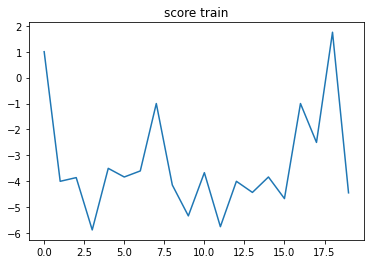

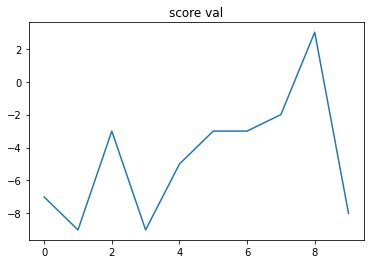

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#from popup_lib.popup import *
from typing import *
import time

class Toy_Env(Abstract_Environment):
    def get_dim_state(self) -> int:
        return 1

    def get_dim_action(self) -> int:
        return 1

    def __init__(self,sigma=1):
        self.value=0
        self.count = 0
        self.sigma=sigma

    def reset(self)->np.ndarray:
        self.value=np.random.uniform(-10,10)
        self.count = 0
        return np.array([self.value])

    def step(self, action):
        self.value+= action + self.sigma * np.random.normal()
        self.count+=1

        terminal_bad = False
        terminal_good = False

        inside = -20 <= self.value <= +20
        if not inside:
            terminal_bad = True

        if terminal_bad:
            reward = -10
        else:
            reward = 1

        # on gagne si la bille reste 100 fois
        if self.count > 100:
            terminal_good = True
            reward = 50

        terminal = terminal_bad or terminal_good
        if terminal:
            self.reset()  # la position est réinitialiser

        return np.array([self.value]), reward, terminal

def actor_maker_fn():
    input_state=tf.keras.layers.Input([1])
    y=tf.keras.layers.Dense(4,activation="relu")(input_state)
    output_action=tf.keras.layers.Dense(1)(y)
    return tf.keras.Model(inputs=input_state,outputs=output_action)

def critic_maker_fn():
    input_state = tf.keras.layers.Input([1])
    input_action = tf.keras.layers.Input([1])
    y_state = tf.keras.layers.Dense(3,activation="relu")(input_state)
    y_action = tf.keras.layers.Dense(3,activation="relu")(input_action)
    y=tf.keras.layers.Concatenate()([y_state,y_action])
    y=tf.keras.layers.Dense(3,activation="relu")(y)
    output_critic = tf.keras.layers.Dense(1)(y)
    return tf.keras.Model(inputs=[input_state,input_action], outputs=output_critic)


""" Attention, parfois cela échoue complétement, et parfois cela réussit très très vite.
Exemple de réussite rapide:
scores
|1.2_record|-4.4|-5.1|8.8_record|13.5_record|77.0_record|150.0_record|150.0_record|150.0_record|112.5|150.0_record|150.0_record|108.5|150.0_record|92.0|150.0_record|150.0_record|86.0|115.3|150.0_recordvalidation:
scores validation:
|78.0|150.0|65.0|150.0|150.0|62.0|150.0|150.0|150.0|150.0
"""
def main():

    agent=Agent_ddqn(Toy_Env(),actor_maker_fn,critic_maker_fn)
    scores=[]
    ite=-1
    print("scores")
    for _ in range(20):
        ite+=1
        score=agent.optimize_return_score()
        print(f"|{score:.1f}",end="")
        scores.append(score)
        if score>=np.max(scores):
            print("_record",end="")
            agent.save_actor_weights()
    fig,ax=plt.subplots()
    ax.set_title("score train")
    ax.plot(scores)

    print("validation:")
    agent.set_saved_actor_weights()
    print("scores validation:")
    scores=[]
    for _ in range(10):
        ite+=1
        score=agent.valid_return_score()
        print(f"|{score:.1f}",end="")
        scores.append(score)

    fig, ax = plt.subplots()
    ax.set_title("score val")
    ax.plot(scores)
    plt.show()


main()

Garre au sur-apprentissage pour des problèmes si simple. 

## Problème en 300D

### Environnement

In [4]:
DIM=300
SIGMA_NOISE=3

def random_sinus_sum(dim):
    res=np.zeros([dim])
    x=np.linspace(0,2*np.pi,dim)
    for i in range(1,10):
        res+=np.random.uniform(-0.2,0.2)*np.sin(i*x)
    return res

"""Il faut bien régler les paramètres sigma et initial_size
 pour que l'on ne gagne pas à chaque coup: utiliser le test_zero_action() pour vérifier """
class Sinus_Env(Abstract_Environment):

    def __init__(self, dim=DIM, sigma_noise=SIGMA_NOISE, initial_size=5, reward_when_win=100):
        self.dim=dim
        self.sigma_noise = sigma_noise
        self.initial_size=initial_size
        self.reward_when_win=reward_when_win
        self.value=np.zeros([dim])
        self.count = 0
        self.render_is_active=False

    def get_dim_state(self) -> int:
        return self.dim

    def get_dim_action(self) -> int:
        return self.dim

    def reset(self)->np.ndarray:
        self.value= random_sinus_sum(self.dim)*self.initial_size
        self.count=0
        return self.value

    def step(self, action):
        assert action.shape==(self.dim,), f"action must have the dimension {self.dim} but shape is {action.shape} "
        self.value+= action + self.sigma_noise * random_sinus_sum(self.dim)
        self.count+=1

        terminal_bad = False
        terminal_good = False

        too_big=np.sum(self.value>20)
        too_small=np.sum(self.value<-20)
        inside = too_big+too_small ==0
        if not inside:
            terminal_bad = True

        if terminal_bad:
            reward = -self.reward_when_win
        else:
            reward = 1

        # on gagne si la fonction reste 100 fois dans les bornes
        if self.count > 200:
            terminal_good = True
            reward = self.reward_when_win

        terminal = terminal_bad or terminal_good
        if terminal:
            self.reset()  # la position est réinitialiser
        if self.render_is_active:
            self._record_for_render()

        return self.value, reward, terminal


    def start_render(self):
        self.render_is_active=True
        self.curves=[]
        self.current_render_stop=0

    def do_render(self):
        x=np.linspace(0,2*np.pi,self.dim)
        self.render_is_active=False
        nb=len(self.curves)
        for i,curve in enumerate(self.curves):
            if i==0:
                alpha=1
                color="r"
            else:
                alpha = i / nb
                color="k"
            plt.plot(x,curve,color,alpha=alpha)
        plt.show()

    def _record_for_render(self):
        self.curves.append(self.value.copy())

def evaluate_policy(env:Sinus_Env, policy):
    rewards=[]
    ep_lengths=[]
    nb_win=0
    nb_test=40
    for _ in range(nb_test):
        r = None
        ep_length = 0
        cum_reward=0
        done=False
        s=env.reset()
        while not done:
            ep_length+=1
            s,r,done=env.step(policy(s))
            cum_reward+=r
        if r==env.reward_when_win:
            nb_win+=1
        ep_lengths.append(ep_length)
        rewards.append(cum_reward)

    print(f"win:{nb_win/nb_test} cum_rewards:{np.mean(rewards)}, episode length:{np.mean(ep_lengths)}")


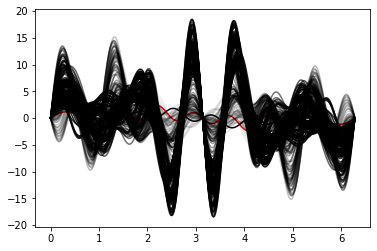

reward:100, count:201


In [5]:
def test_env_graph():
    dim=300
    env=Sinus_Env(dim)
    zero_action=np.zeros([dim])
    done=False
    env.start_render()
    r=0
    count=0
    while not done:
        count+=1
        s_,r,done=env.step(zero_action)
    env.do_render()
    print(f"reward:{r}, count:{count}")

test_env_graph()

In [6]:
def test_zero_policy():
    env=Sinus_Env(DIM)
    policy=lambda state:np.zeros([env.dim])
    evaluate_policy(env, policy)
test_zero_policy()

win:0.15 cum_rewards:67.25, episode length:138.25


### Apprentissage (pas encore top)

The zero policy gives:
win:0.2 cum_rewards:75.0, episode length:136.0
score and std*10000
|-82,909.16_record|-94,877.81|-96,856.08|-97,839.09|-97,822.43|-98,810.16|-98,798.07|-98,786.15|-98,774.42|-98,762.86|-98,751.48|-98,740.26|-98,729.21|-97,714.74|-95,693.56|-78,618.04_record|-86,573.27|-90,542.52|-86,503.22|-80,452.95|-51,352.53_record|32,181.00_record|17,100.18|1,60.08|-3,36.76|-33,26.14|-36,18.87|-44,14.18|-13,9.12|13,5.15|33,2.63_record|12,1.49|-9,0.94|41,0.46_record|5,0.27|-24,0.18|86,0.07_record|33,0.04|-17,0.02|-59,0.02|75,0.01|6,0.00|-38,0.00|58,0.00|30,0.00|-3,0.00|41,0.00|-19,0.00|16,0.00|-9,0.00|10,0.00|5,0.00|-6,0.00|44,0.00|4,0.00|-44,0.00|-9,0.00|65,0.00|-10,0.00|-46,0.00|-10,0.00|27,0.00|-15,0.00|36,0.00|77,0.00|-17,0.00|-44,0.00|-5,0.00|-32,0.00|2,0.00|21,0.00|-31,0.00|-37,0.00|10,0.00|10,0.00
 validation, scores:
|39.0|28.0|4.0|18.0|9.0
evaluation de la politique apprise
win:0.025 cum_rewards:17.9, episode length:113.9


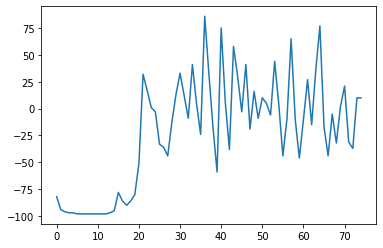

In [7]:
def analyse_layer(y):
    y = tf.keras.layers.Conv1D(6, 5, activation="relu", padding="same")(y)
    y = tf.keras.layers.Conv1D(6, 5, activation="relu", padding="same")(y)
    y = tf.keras.layers.Conv1D(6, 5, activation="relu", padding="same")(y)
    return y

def actor_maker_fn():
    input_state=tf.keras.layers.Input([DIM,1])
    y=analyse_layer(input_state)
    output_action=tf.keras.layers.Conv1D(1,5,padding="same")(y)
    #il faut une action de taille comparable au bruit pour pouvoir le compenser
    output_action=output_action[:,:,0]*SIGMA_NOISE
    return tf.keras.Model(inputs=input_state,outputs=output_action)

def critic_maker_fn():
    input_state = tf.keras.layers.Input([DIM,1])
    input_action = tf.keras.layers.Input([DIM,1])
    y_state = analyse_layer(input_state)
    y_action = analyse_layer(input_action)
    y=tf.keras.layers.Concatenate()([y_state,y_action])
    y=analyse_layer(y)
    output_critic = tf.keras.layers.Conv1D(1,5,padding="same")(y)
    output_critic = output_critic[:,:,0]
    return tf.keras.Model(inputs=[input_state,input_action], outputs=output_critic)

def test_models():
    batch_size=3
    input_action=np.random.normal(size=[batch_size,DIM,1])
    input_critic = np.random.normal(size=[batch_size,DIM,1])
    model_actor=actor_maker_fn()
    model_critic=critic_maker_fn()
    res_actor=model_actor(input_action).numpy()
    print(f"actor result shape{res_actor.shape} , sdt:{np.std(res_actor.flatten())}")
    res_critic=model_critic([input_action,input_critic]).numpy()
    print(f"actor result shape{res_critic.shape} , sdt:{np.std(res_critic.flatten())}")

#test_models()

def main():
    env=Sinus_Env()
    print("The zero policy gives:")
    evaluate_policy(env, lambda state: np.zeros([env.dim]))

    agent=Agent_ddqn(env,actor_maker_fn,critic_maker_fn,
                     perturb_action_sigma=1e-2,
                     min_minutes_before_score=0)
    scores=[]
    ite=-1
    minutes=6
    ti0=time.time()
    print("score and std*10000")
    try:
        while time.time()-ti0<minutes*60:
            ite+=1
            score=agent.optimize_return_score()
            print(f"|{score:.0f},{agent.std*100000:.2f}",end="")
            scores.append(score)
            if score >= np.max(scores):
                print("_record", end="")
                agent.save_actor_weights()
    except KeyboardInterrupt:
        print("\ninteruption")


    print("\n validation, scores:")
    agent.set_saved_actor_weights()
    for _ in range(5):
        score_val = agent.valid_return_score()
        print(f"|{score_val:.1f}",end="")
    print("\nevaluation de la politique apprise")
    evaluate_policy(env,lambda state:agent.policy(state,val_mode=True))

    plt.plot(scores)
    plt.show()

    #todo: ploter des couples state,politique(state) pour comprendre

main()

Bon, faut avoir pas mal de chance pour réussir mais ça marche parfois.